In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

In [5]:
infected_folder = 'Infected'
infected_images = load_images_from_folder(infected_folder)
n_infected_folder = 'Not_Infected'
n_intected_images = load_images_from_folder(n_infected_folder)

In [15]:
itr = round(501*0.5)
ival = round(550*0.1)
ite = round(501*0.4)

ntr = round(550*0.5)
nval = round(550*0.1)
nte = round(550*0.4)

In [16]:
covid_dir = 'Covid_CT'
os.mkdir(covid_dir)

In [17]:
# train, val, test folder
train_dir = './Covid_CT/train'
val_dir = './Covid_CT/val'
test_dir = './Covid_CT/test'

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

# infected folder
in_train = './Covid_CT/train/infected'
in_val = './Covid_CT/val/infected'
in_test = './Covid_CT/test/infected'

os.mkdir(in_train)
os.mkdir(in_val)
os.mkdir(in_test)

#not infected folder
not_in_train = './Covid_CT/train/Not_infected'
not_in_val = './Covid_CT/val/Not_infected'
not_in_test = './Covid_CT/test/Not_infected'

os.mkdir(not_in_train)
os.mkdir(not_in_val)
os.mkdir(not_in_test)

In [18]:
def infected_images_to_folder(infected_images, train_dir, val_dir, test_dir):
    for i in range(len(infected_images)):
        img_name = "{}.jpg".format(i)
        if i in range(0, itr+1):
            cv2.imwrite(os.path.join(train_dir, img_name), infected_images[i])
        elif i in range(itr+1, itr+ival+1):
            cv2.imwrite(os.path.join(val_dir, img_name), infected_images[i])
        else:
            cv2.imwrite(os.path.join(test_dir, img_name), infected_images[i])

In [19]:
def not_infected_images_to_folder(n_intected_images, train_dir, val_dir, test_dir):
    for i in range(len(n_intected_images)):
        img_name = "{}.jpg".format(i)
        if i in range(0, ntr+1):
            cv2.imwrite(os.path.join(train_dir, img_name), n_intected_images[i])
        elif i in range(ntr+1, ntr+nval+1):
            cv2.imwrite(os.path.join(val_dir, img_name), n_intected_images[i])
        else:
            cv2.imwrite(os.path.join(test_dir, img_name), n_intected_images[i])

In [ ]:
infected_images_to_folder(infected_images, './Covid_CT/train/infected', './Covid_CT/val/infected', './Covid_CT/test/infected')
not_infected_images_to_folder(n_intected_images, './Covid_CT/train/Not_infected', './Covid_CT/val/Not_infected', './Covid_CT/test/Not_infected')

In [7]:
h, w = infected_images[0].shape
h, w

(512, 512)

In [8]:
from tensorflow.keras.preprocessing.image import img_to_array
infected_images = img_to_array(infected_images)
n_intected_images = img_to_array(n_intected_images)

In [16]:
clahe = cv2.createCLAHE(clipLimit=3.0)
def clahe_enhancer(img, clahe, axes):
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

In [17]:
fig, axes = plt.subplots(3, 6, figsize=(18,8))  
img_size = 512

for ii in range(0,6):
    img = cv2.resize(infected_images[ii], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


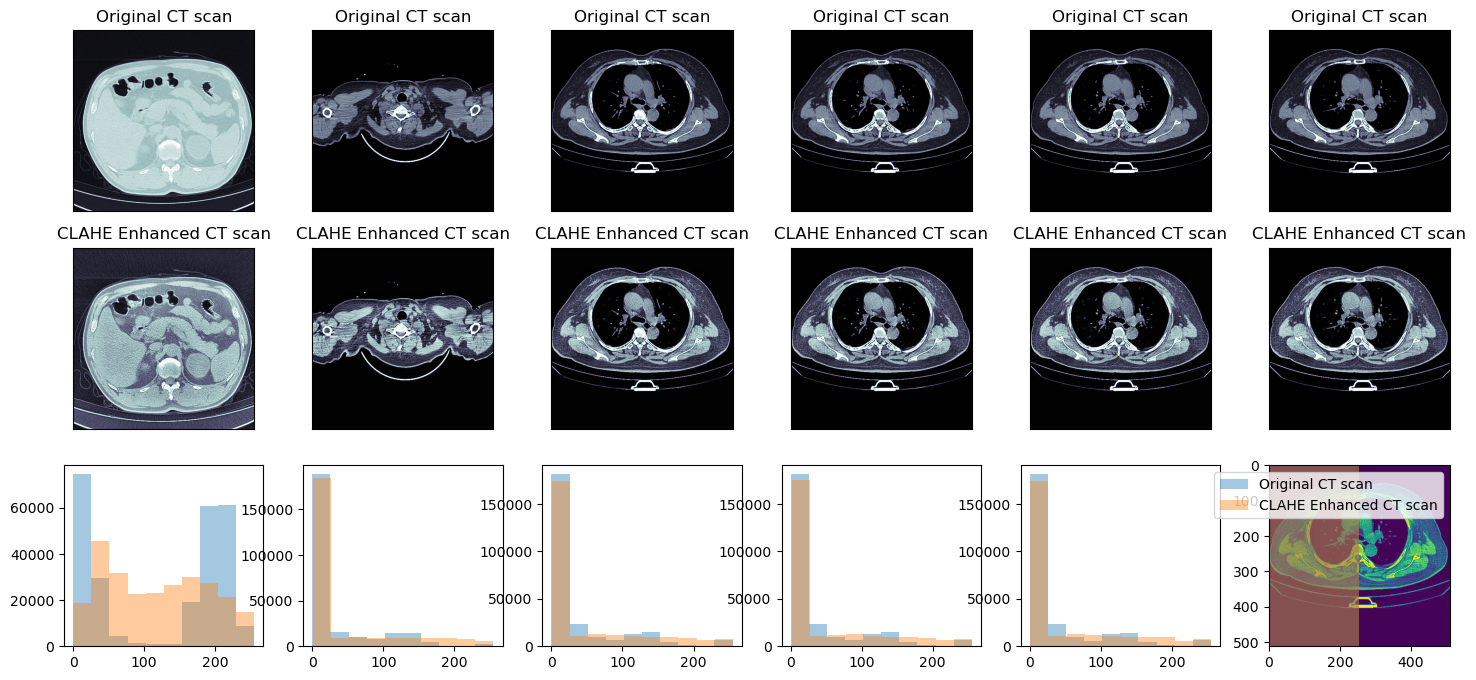

In [18]:
plt.imshow(clahe_img)
plt.show()

In [48]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

vali_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)

validation_generator = vali_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 30,
    class_mode = 'binary',
    color_mode='grayscale'
)

# 2. Dropout 추가 및 Dense Node를 줄인다. & 4. 이미지 픽셀을 더 작게 150*150으로 축소한다.
IMAGE_ROWS = 150
IMAGE_COLS = 150
BATCH_SIZE = 30
IMAGE_SHAPE = (IMAGE_ROWS,IMAGE_COLS,1)



model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.7))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.7))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), # 'rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=15, epochs=10, validation_data = validation_generator, validation_steps = 1)

Found 527 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 414 images belonging to 2 classes.
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 82944)             0      

In [49]:
tr_score = model.evaluate_generator(train_generator)
print('Train Loss : {:.4f}'.format(tr_score[0]))
print('Train Accuracy : {:.4f}'.format(tr_score[1]))

te_score = model.evaluate(test_generator)
print('Test Loss : {:.4f}'.format(te_score[0]))
print('Test Accuracy : {:.4f}'.format(te_score[1]))

Train Loss : 0.2285
Train Accuracy : 0.9526
14/14 [==============================] - 2s 137ms/step - loss: 0.9126 - acc: 0.4106
Test Loss : 0.9126
Test Accuracy : 0.4106


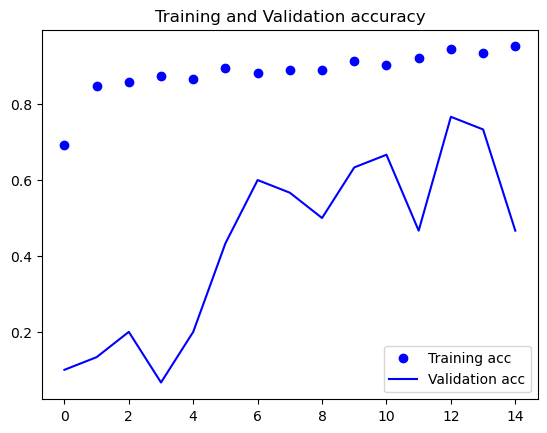

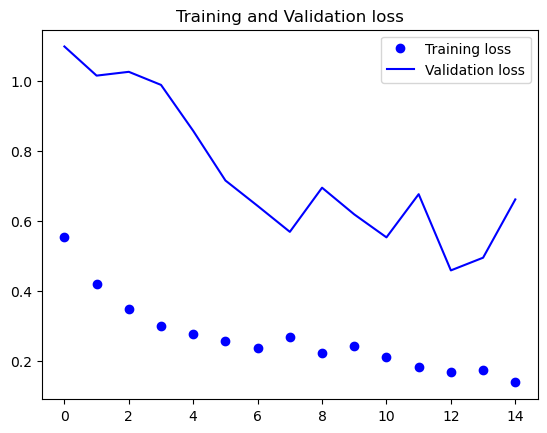

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [50]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='CNN1.png', show_shapes=True)

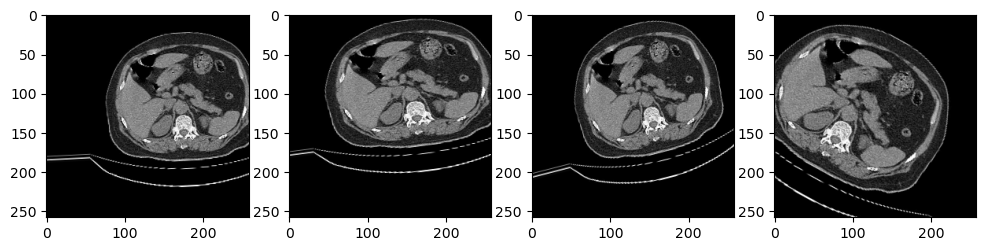

In [38]:
import os
from tensorflow.keras.preprocessing import image

one_fname = r'C:\Users\parks\OneDrive\COVID-19_CT\Covid_CT\train\infected\202.jpg'
img = image.load_img(one_fname, target_size=(258,258))

x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)

i = 0
plt.figure(figsize=(12,6))

for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(1, 4,i+1)
    plt.imshow(image.array_to_img(batch[0]))

    i += 1
    if i % 4 == 0:
        break

plt.show()

[[[21 21 21]
  [20 20 20]
  [17 17 17]
  ...
  [10 10 10]
  [23 23 23]
  [16 16 16]]

 [[18 18 18]
  [17 17 17]
  [18 18 18]
  ...
  [20 20 20]
  [19 19 19]
  [15 15 15]]

 [[17 17 17]
  [17 17 17]
  [19 19 19]
  ...
  [ 7  7  7]
  [18 18 18]
  [28 28 28]]

 ...

 [[16 16 16]
  [20 20 20]
  [20 20 20]
  ...
  [16 16 16]
  [21 21 21]
  [18 18 18]]

 [[14 14 14]
  [17 17 17]
  [22 22 22]
  ...
  [10 10 10]
  [19 19 19]
  [19 19 19]]

 [[23 23 23]
  [16 16 16]
  [17 17 17]
  ...
  [14 14 14]
  [19 19 19]
  [14 14 14]]]


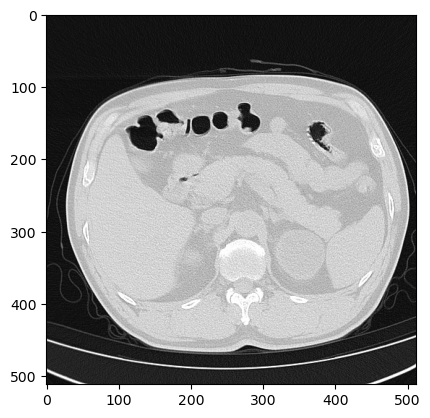

In [28]:
img = cv2.imread(r'C:\Users\parks\OneDrive\COVID-19_CT\Infected\(1).jpg')
print(img)
plt.imshow(img)
plt.show()

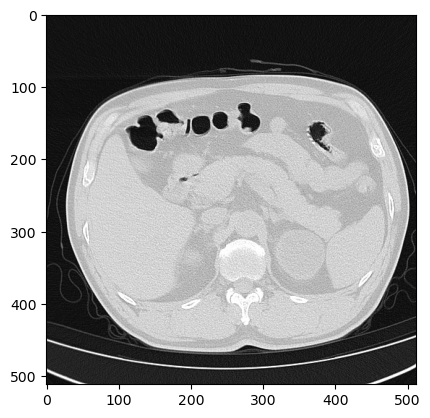

In [22]:
img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
plt.imshow(img)
plt.show()

In [23]:
xmax, xmin = img.max(), img.min()

In [26]:
xmin

0

In [27]:
img = (img - xmin)/(xmax - xmin)
img

array([[[0.08235294, 0.08235294, 0.08235294],
        [0.07843137, 0.07843137, 0.07843137],
        [0.06666667, 0.06666667, 0.06666667],
        ...,
        [0.03921569, 0.03921569, 0.03921569],
        [0.09019608, 0.09019608, 0.09019608],
        [0.0627451 , 0.0627451 , 0.0627451 ]],

       [[0.07058824, 0.07058824, 0.07058824],
        [0.06666667, 0.06666667, 0.06666667],
        [0.07058824, 0.07058824, 0.07058824],
        ...,
        [0.07843137, 0.07843137, 0.07843137],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        [0.05882353, 0.05882353, 0.05882353]],

       [[0.06666667, 0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667],
        [0.0745098 , 0.0745098 , 0.0745098 ],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.07058824, 0.07058824, 0.07058824],
        [0.10980392, 0.10980392, 0.10980392]],

       ...,

       [[0.0627451 , 0.0627451 , 0.0627451 ],
        [0.07843137, 0.07843137, 0.07843137],
        [0.07843137, 0

In [29]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv2.filter2D(img, -1, kernel)
    
    ret, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, 2, 1)
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)
    
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv2.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for ii in range(0,6):
    img = cv2.resize(infected_images[ii], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

In [ ]:
infected_f = []

for ii in range(infected_images.shape[0]):
    img_ct = cv2.resize(infected_images[ii], dsize=(img_size, img_size), 
                        interpolation=cv2.INTER_AREA)
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    infected_f.append(cropped_ct)

In [ ]:
n_infected_f = []

for ii in range(n_intected_images.shape[0]):
    img_ct = cv2.resize(n_intected_images[ii], dsize=(img_size, img_size), 
                        interpolation=cv2.INTER_AREA)
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    n_infected_f.append(cropped_ct)

In [ ]:
num_pix = 512
del_lst = []
for ii in tqdm.tqdm(range(len(infected_f))) :
    try :
        infected_f[ii] = cv2.resize(infected_f[ii], dsize=(num_pix, num_pix), interpolation=cv2.INTER_AREA)
        infected_f[ii] = np.reshape(infected_f[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del infected_f[idx]

In [ ]:
num_pix = 512
del_lst = []
for ii in tqdm.tqdm(range(len(n_infected_f))) :
    try :
        n_infected_f[ii] = cv2.resize(n_infected_f[ii], dsize=(num_pix, num_pix), interpolation=cv2.INTER_AREA)
        n_infected_f[ii] = np.reshape(n_infected_f[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del n_infected_f[idx]

In [ ]:
plt.figure()

plt.imshow(infected_f[0][:,:,0], cmap='bone') # 0번째
plt.title("Enhanced & Cropped CT")

In [ ]:
plt.figure()

plt.imshow(infected_f[56][:,:,0], cmap='bone') # 56번째
plt.title("Enhanced & Cropped CT")

In [ ]:
# 랜덤하게 섞기
import random
random.seed(12345)

random.shuffle(n_infected_f)
random.shuffle(infected_f)

In [ ]:
ntr = round(550*0.5)
nval = round(550*0.1)
nte = round(550*0.4)

itr = round(501*0.5)
ival = round(550*0.1)
ite = round(501*0.4)

In [ ]:
covid_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3'
os.mkdir(covid_dir)

train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train'
vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate'
test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test'

os.mkdir(train_dir)
os.mkdir(vali_dir)
os.mkdir(test_dir)

In [ ]:
train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train/Infected'
vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate/Infected'
test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test/Infected'

os.mkdir(train_dir)
os.mkdir(vali_dir)
os.mkdir(test_dir)

In [ ]:
train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train/n_Infected'
vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate/n_Infected'
test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test/n_Infected'

os.mkdir(train_dir)
os.mkdir(vali_dir)
os.mkdir(test_dir)

In [ ]:
import os, shutil

def ninfected_images_to_folder(n_infected):
    train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train/n_Infected/'
    vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate/n_Infected/'
    test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test/n_Infected/'

    for i in range(len(n_infected)):
        if i in range(0,ntr+1):
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(train_dir + fname)), n_infected[i])
            cv2.waitKey(0)
        elif i in range(ntr+1,ntr+nval+1):
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(vali_dir + fname)), n_infected[i])
            cv2.waitKey(0)
        else:
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(test_dir + fname)), n_infected[i])
            cv2.waitKey(0)

In [ ]:
def infected_images_to_folder(infected):
    train_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/train/Infected/'
    vali_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/validate/Infected/'
    test_dir = '/content/gdrive/My Drive/CNN/COVID_CT_NEW3/test/Infected/'

    for i in range(len(infected)):
        if i in range(0,itr+1):
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(train_dir + fname)), infected[i])
            cv2.waitKey(0)
        elif i in range(itr+1,itr+ival+1):
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(vali_dir + fname)), infected[i])
            cv2.waitKey(0)
        else:
            fname = '{}.jpg'.format(i)
            cv2.imwrite(os.path.join(str(test_dir + fname)), infected[i])
            cv2.waitKey(0)

In [ ]:
ninfected_images_to_folder(n_infected_f)
infected_images_to_folder(infected_f)